In [1]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join

from scipy import interpolate
import scipy.stats as stats
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

#-- bins for clustering (data and mocks)
from params import H0, bin_file_comoving#, bin_file

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:550: UserWarning: matplotlibrc text.usetex can not be used unless ghostscript-9.00 or later is installed on your system
  % gs_req)


# Set parameters


In [2]:
band   = "Mz"
zrange = (0.4,0.5)

sigma_sham_array = np.round(np.arange(0.5,0.651,0.01),2)
sigma_los_array  = np.arange(50,121,10)

rp_use_range = (0.1, None)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.
print(f"h = {h}")

boxsize = get_boxsize(sim_tag)

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps  = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
else:
    raise Exception()

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band, nbins=n_mag_bins_clust)

lf_name  = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()

abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)
#=========== END HOUSEKEEPING ===========#

t = Table(np.load(f"{BASEDIR}/mags_{cat_tag}_noLRG.npy"))

abs_mag_bin_cens   = [np.mean(abs_mag_bins_clust[i:i+2]) for i in range(len(abs_mag_bins_clust)-1)]
abs_mag_bin_means  = [np.round(  np.mean( t[band][ (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])] ),3) for i in range(len(abs_mag_bins_clust)-1)]

print(band)
print(zrange)

params = dict(band=band,
              zrange=zrange, zmin=zmin, zmax=zmax,
              rp_use_range=rp_use_range,
              zmag_lim=zmag_lim,
              sim_tag=sim_tag,
              sham_tag=sham_tag,
              d=d,
              pimax=pimax,
              h=h,
              z_snaps=z_snaps,
              snap_nums=snap_nums,
              a_snaps=a_snaps,
              snaps=snaps,
              hist_idx=hist_idx,
              vol_sim=vol_sim,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              cat_tag=cat_tag,
              abs_mag_lim=abs_mag_lim,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              zmag_tag=zmag_tag,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              n_mag_bins_clust=n_mag_bins_clust,
              abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              lum_func_full=lum_func_full,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")



h = 0.6777


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Mz
(0.4, 0.5)


In [3]:
cross = "GXG"
brightest_mag_bin_rp1Mpch = False

rp_bins, rp_mids = rp_bins_from_file(bin_file_comoving)

out = {}

for idx,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
    print(abs_mag_bin_tag)
    sigma_sham_col = []
    sigma_los_col  = []
    chisq_col      = []
    pct_diff_1h    = []
    pct_diff_2h    = []
    
    #-- DATA
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

    data   = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"].data
    wp_dat = h*data["wp"].data
    wp_err = h*np.sqrt(data["wp_err"].data)

    rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
    cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_mids, pimax=pimax)
    cov_inv = np.linalg.inv(cov)

    #-- rp bins to include in chisq
    rp_use_min, rp_use_max = rp_use_range
    if (brightest_mag_bin_rp1Mpch==True) and ("n30p0" in abs_mag_bin_tag):
        if (rp_use_max != None):
            rp_use_idx = np.where((rp_cen > 1.0) & (rp_cen < rp_use_max))[0]
        else:
            rp_use_idx = np.where(rp_cen > 1.0)[0]
    else:
        if (rp_use_min != None) & (rp_use_max != None):
            rp_use_idx = np.where((rp_cen > rp_use_min) & (rp_cen < rp_use_max))[0]
        elif (rp_use_min != None) & (rp_use_max==None):
            rp_use_idx = np.where(rp_cen > rp_use_min)[0]
        elif (rp_use_min==None) & (rp_use_max != None):
            rp_use_idx = np.where(rp_cen < rp_use_max)[0]
        else:
            rp_use_idx = np.arange(len(rp_cen))
    N_rp = len(rp_use_idx)

    rp_use_tag = get_rp_use_tag(rp_use_range, brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch,
                                return_tag=True, return_label=False)

    #-- MODELS
    for sigma_sham in sigma_sham_array:
        sigma_sham_tag = f"sigma_sham_const{str(sigma_sham).replace('.','p')}"
        fpath = f"{BASEDIR}/clustering/mocks/{sim_tag}/{sham_tag}/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/{sigma_sham_tag}"
        if os.path.exists(fpath):
            wp_fname = f"{zsnap_tag}_{d}_{cross}_pimax{int(pimax)}.npy"

            wp_models = np.load(f"{fpath}/{wp_fname}").item()

            for sigma_los in sigma_los_array:
                sigma_los_key = f"sigma_los_{int(sigma_los)}"
                if sigma_los_key in wp_models.keys():
                    #print(sigma_sham, sigma_los)
                    wp_mod = Table(wp_models[f"sigma_los_{int(sigma_los)}"])["wp"].data
                    chisq  = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])

                    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
                    two_halo = (rp_cen > 1.0)
                    pct_diff = 1 - wp_mod/wp_dat
                    #print( f"{np.mean(pct_diff[one_halo]):.3f} {np.mean(pct_diff[two_halo]):.3f}" )

                    sigma_sham_col.append(sigma_sham)
                    sigma_los_col.append(sigma_los)
                    chisq_int = int(chisq) if (chisq>0) else chisq
                    chisq_col.append(chisq_int)
                    pct_diff_1h.append(np.round(pct_diff[one_halo],3))
                    pct_diff_2h.append(np.round(pct_diff[two_halo],3))
            
    out[abs_mag_bin_tag] = Table(data=(chisq_col,sigma_sham_col,sigma_los_col,pct_diff_1h,pct_diff_2h),
                                 names=("chisq","sigma_sham","sigma_los","pct_diff_1h","pct_diff_2h"))

save_path = f"{BASEDIR}/chisq/{rp_use_tag}"
save_fname = f"{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"

Path( save_path ).mkdir(parents=True, exist_ok=True)

print(f"Saving {save_path}/{save_fname}...")
np.save(f"{save_path}/{save_fname}", out, allow_pickle=True)
                        

Mzn30p0-n22p35
Mzn22p35-n22p1
Mzn22p1-n21p85
Mzn21p85-n21p6
Saving /Users/aberti/Desktop/research/desi_lrg_sham/chisq/rpmin0p1Mpch/south_vpeak_Mzlimn21p6_zsnap0p42531.npy...


In [4]:
def load_chisq_linear(rp_use_range=None, d="south", band=None, zmin=None, sim_tag=None, coarse=False,
                      brightest_mag_bin_rp1Mpch=False):
    assert(sim_tag != None)
    rp_use_tag = get_rp_use_tag(rp_use_range, brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch, return_tag=True)

    out = []

    abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=4)
    #print(abs_mag_bins_clust)
    
    z_snaps,_,_ = get_zsnap_data(sim_tag)
    zsim      = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    zsim = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
    zsnap_tag = get_zsnap_tag(zsim)

    abs_mag_lim = get_abs_mag_lim(zmin, band)
    if band=="Mz":
        abs_mag_lim_tag = get_Mz_tag(abs_mag_lim)
    elif band=="MW1":
        abs_mag_lim_tag = get_MW1_tag(abs_mag_lim)

    #-- load linear fit mag bin chisq data
    #print(rp_use_tag)
    if coarse==True:
        fname = f"{BASEDIR}/chisq/{rp_use_tag}/{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}_coarse.npy"
    else:
        fname = f"{BASEDIR}/chisq/{rp_use_tag}/{d}_{sham_tag}_{abs_mag_lim_tag}_{zsnap_tag}.npy"
    #print(fname)
    chisq_linear = np.load(fname, allow_pickle=True).item()

    #-- parse mag bin keys
    mag_bin_tags = list(chisq_linear.keys())

    #-- define mag bin centers
    mag_bin_edges = [-float(j[1:].replace("p",".")) for j in np.array([i.split("-") for i in mag_bin_tags]).T[1]]
            
    return chisq_linear
        

## View fine-grained parameter space grid

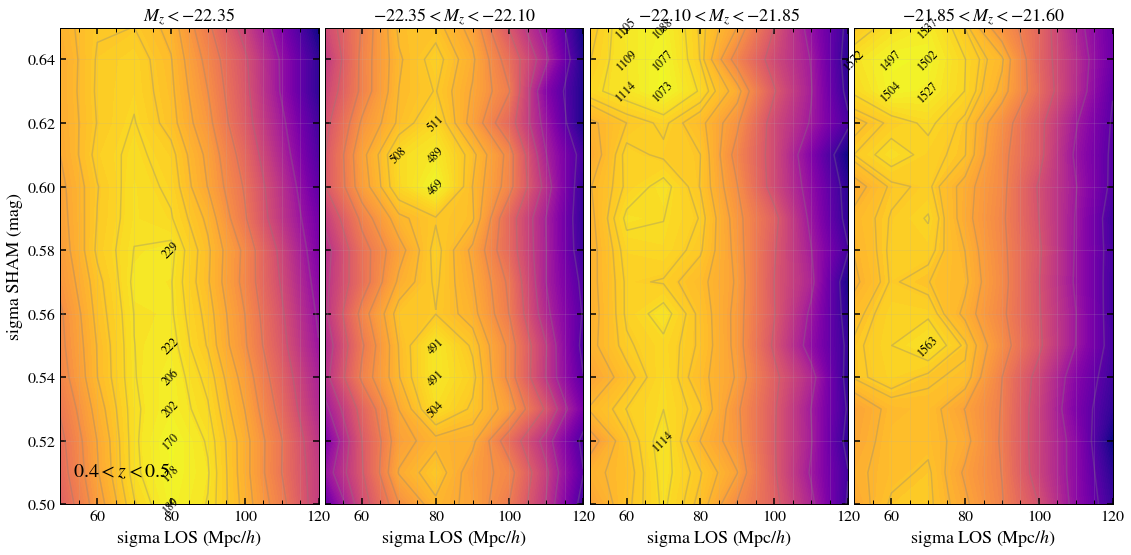

In [5]:
import matplotlib.colors as colors

brightest_mag_bin_rp1Mpch = False
save = False

chisq_linear = load_chisq_linear(rp_use_range=rp_use_range, sim_tag=sim_tag, band=band, zmin=zmin,
                                 brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)

fig1, axes = plt.subplots(1,4,figsize=(16,8), sharex=True, sharey=True)

mag_bin_tags = list(chisq_linear.keys())
    
y_sham = []
y_los  = []
chisq_val = []

for mag_bin_idx,ax in zip(np.arange(4),axes):
    tab = chisq_linear[mag_bin_tags[mag_bin_idx]]
    
    tab = tab[ (tab["sigma_los"] >= np.min(sigma_los_array)) & (tab["sigma_los"] <= np.max(sigma_los_array)) ]

    sigma_los  = tab["sigma_los"].data
    sigma_sham = tab["sigma_sham"].data
    chisq      = tab["chisq"].data

    zz = chisq.reshape(len(np.unique(sigma_sham)), len(np.unique(sigma_los)))
    
    quant  = np.linspace(0,1,101)
    levels = np.quantile(zz, quant)
    levels_gray  = levels[::-10][::-1]

    ax.contourf(np.unique(sigma_los), np.unique(sigma_sham), zz, cmap="plasma_r", levels=100)
    ax.contour(np.unique(sigma_los), np.unique(sigma_sham), zz, colors="gray", alpha=0.3, levels=levels_gray)

    tab.sort("chisq")
    assert(tab["chisq"][0] < tab["chisq"][-1])

    show = tab[tab["chisq"] <= np.percentile(tab["chisq"],5)]
    sigma_los_mins  = show["sigma_los"].data
    sigma_sham_mins = show["sigma_sham"].data

    for i in range(len(show)):
        ax.text(sigma_los_mins[i], sigma_sham_mins[i], show["chisq"][i], ha="center", va="center", fontsize=12, rotation=45)
    title = get_abs_mag_bin_label(mag_bin_tags[mag_bin_idx])
    if (brightest_mag_bin_rp1Mpch==True) & (mag_bin_idx==0):
        title += r" $(r_{\rm p} > 1$ Mpch/$h$)"
    ax.set_title(title)
    
for ax in axes:
    ax.set_xlabel("sigma LOS (Mpc/$h$)")
    # ax.set_xlim(60,130)
    ax.grid(alpha=0.2, which="both")

axes[0].set_ylabel("sigma SHAM (mag)")
# axes[0].set_ylim(0.69,0.91)
# axes[0].set_yticks(np.arange(0.7,0.905,0.05))

# axes[0].text(*get_corners(axes[0])["lower_right"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="right", va="bottom")
axes[0].text(*get_corners(axes[0])["lower_left"], f"${zmin} < z < {zmin+0.1}$", fontsize=20, ha="left", va="bottom")

plt.tight_layout()
plt.subplots_adjust(wspace=0.025)

if save:
    figname = f"{BASEDIR}/figures/chisq-grid_{cat_tag[:-6]}_{band}_pct-diff.png"
    print(figname)
    plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [6]:
%%time

mock_fname = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{abs_mag_lim_tag}.npy"

print(f"Loading {mock_fname}...")

halocat = Table(np.load(mock_fname))

halocat = halocat[halocat[f"{band}_no_scatter"] < np.inf]


Loading /Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p42531_Mzlimn21p6.npy...
CPU times: user 9.66 s, sys: 16.6 s, total: 26.3 s
Wall time: 37.5 s


In [7]:
abs_mag_bins = np.round(lum_func_full["abs_mag_bins"],2)

# print("max galaxy number density")
# print( np.max( np.array(lum_func_full["ng_eff"]) ) )
print("galaxy number density at magnitude limit [Mpc^(-3)]:")
print( np.max( np.array(lum_func_full["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] ) )

# print(int(np.max( np.array(lum_func_full["ng_eff"]) ) * (vol_sim/(h**3)) ))
Nhalo_select = int(np.max( np.array(lum_func_full["ng_eff"])[np.where(abs_mag_bins <= abs_mag_lim)] ) * (vol_sim/(h**3)) )

print("\nnumber of halos to select to achieve target number density:")
print(Nhalo_select)

print(len(halocat[halocat[f"{band}_no_scatter"] <= abs_mag_lim]))

brightest_mag_bin_rp1Mpch = False

chisq_linear = load_chisq_linear(rp_use_range=rp_use_range, sim_tag=sim_tag, band=band, zmin=zmin,
                                 brightest_mag_bin_rp1Mpch=brightest_mag_bin_rp1Mpch)

mag_bin_tags = list(chisq_linear.keys())
n_iter   = 1
nthreads = 2
DS       = 1
cross    = "GXG"
nsig_clip = 2.5


galaxy number density at magnitude limit [Mpc^(-3)]:
0.0018898983721830406

number of halos to select to achieve target number density:
6071919
6486602


In [8]:
%%time

out_array = []
    
for sigma_sham_const in sigma_sham_array[(sigma_sham_array >= 0.5) & (sigma_sham_array <= 0.65)]:
    sigma_sham_const = np.round(sigma_sham_const,2)
    print(f"{now()} {sigma_sham_const}")
    y_los     = []
    chisq_val = []

    for mag_bin_idx in range(len(mag_bin_tags)):
        tab = chisq_linear[mag_bin_tags[mag_bin_idx]]
        tab = tab[ (tab["sigma_sham"] == sigma_sham_const) ]

        sigma_los = tab["sigma_los"].data
        chisq     = tab["chisq"].data

        use = tab[chisq==np.min(chisq)]
        y_los.append( np.mean(use["sigma_los"].data) )
        chisq_val.append( np.mean(use["chisq"].data) )

    m_los4, b_los4 = np.polyfit( abs_mag_bin_means, y_los, deg=1)

    for c in halocat.colnames:
        if (f"{band}_sig" in c) | (c==f"{band}_scattered") | (c==band):
            halocat.remove_column(c)
            
    #-- constant sham scatter
    sigma_abs_mag_inferred = sigma_sham_const

    #-- add scatter to inferred magnitudes
    abs_mag_inferred_scattered = stats.truncnorm.rvs(-nsig_clip, nsig_clip, halocat[f"{band}_no_scatter"],
                                                     sigma_abs_mag_inferred)
    
    #-- add inferred magnitudes (with SCATTERED Vcirc correspondence) to halo catalog
    #-- temporary column for intermediate SHAM step
    cname_temp = f"{band}_scattered"
    if cname_temp in halocat.colnames:
        halocat.remove_column( cname_temp )
    halocat.add_column( Column(abs_mag_inferred_scattered, name=cname_temp) )

    halocat.sort( cname_temp )

    abs_mag_inferred_sorted = halocat.copy()[f"{band}_no_scatter"]
    abs_mag_inferred_sorted.sort()

    cname_final = f"{band}"

    if cname_final in halocat.colnames:
        halocat.remove_column( cname_final )
    halocat.add_column( Column(abs_mag_inferred_sorted, name=cname_final) )

    this_galcat = halocat[ halocat[band] <= abs_mag_lim ]

    #-- sort catalog by model magnitude
    this_galcat.sort( band )
    assert(this_galcat[band][0] < this_galcat[band][-1])

    #-- add column for galaxy flag
    if "galaxy" not in this_galcat.colnames:
        this_galcat.add_column( Column(np.zeros(len(this_galcat),dtype=bool), name="galaxy"))

    #-- flag halos with galaxies
    this_galcat["galaxy"][:Nhalo_select] = True

    this_galcat = this_galcat[ this_galcat["galaxy"]==True ]
    
    model_mags = this_galcat[band].data

    sigma_los = m_los4*model_mags.data + b_los4
    sigma_los[sigma_los < 0] = 0

    chisq_array = []
    for i,abs_mag_bin_tag in enumerate(abs_mag_bin_tags):
        #-- DATA
        fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp"
        wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

        data   = ascii.read(f"{fpath}/{wp_fname}")
        rp_cen = h*data["rp_cen"].data
        wp_dat = h*data["wp"].data
        wp_err = h*np.sqrt(data["wp_err"].data)

        rp_pi_counts_fname = f"{fpath[:-3]}/rp_pi_counts/{cat_tag}_{cross}.npy"
        cov     = cov_from_rp_pi(rp_pi_counts_fname, cross=cross, rp_mids=rp_cen, pimax=pimax)
        cov_inv = np.linalg.inv(cov)

        #-- MODEL
        mag_min, mag_max = abs_mag_bins_clust[i:i+2]
        mag_mask = (model_mags > mag_min) & (model_mags <= mag_max)

        out = []
        for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
            xx = this_galcat[u]
            yy = this_galcat[v]
            zz = this_galcat[w]
            z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
            z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
            z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

            args = (boxsize, pimax, nthreads, bin_file_comoving, xx[mag_mask][::DS], yy[mag_mask][::DS])
            out.append([wp_corrfunc(*args, z_s[mag_mask][::DS], output_rpavg=False)["wp"] for z_s in z_scatter])
        out = np.concatenate(out).T
        wp_mod = np.mean(out, axis=1)

        chisq = np.sum([ [ (wp_dat - wp_mod)[i]*cov_inv[i,j]*(wp_dat - wp_mod)[j] for i in rp_use_idx ] for j in rp_use_idx ])
        #print( f"{int(chisq)}")
        chisq_array.append(int(chisq))

    #-- DATA
    fpath    = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins/wp"
    wp_fname = f"{cat_tag}_{cross}_pimax{int(pimax)}.txt"

    data   = ascii.read(f"{fpath}/{wp_fname}")
    rp_cen = h*data["rp_cen"].data
    wp_dat = h*data["wp"].data
    wp_err = h*np.sqrt(data["wp_err"].data)

    #-- MODEL
    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx = this_galcat[u]
        yy = this_galcat[v]
        zz = this_galcat[w]
        z_scatter = np.array([np.random.normal(zz, sigma_los, len(zz)) for idx in range(n_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        args = (boxsize, pimax, nthreads, bin_file_comoving, xx[::DS], yy[::DS])
        out.append([wp_corrfunc(*args, z_s[::DS], output_rpavg=False)["wp"] for z_s in z_scatter])
    out = np.concatenate(out).T
    wp_mod = np.mean(out, axis=1)

    one_halo = (rp_cen > 0.1) & (rp_cen < 1.0)
    two_halo = (rp_cen > 1.0)
    pct_diff = 1 - wp_mod/wp_dat
    #print( f"{np.mean(pct_diff[one_halo]):.2f}\n{np.mean(pct_diff[two_halo]):.2f}" )

    row = np.concatenate(np.array([ [np.round(sigma_sham_const,2)], chisq_array,
                                    [np.round(np.mean(pct_diff[one_halo]),2)],
                                    [np.round(np.mean(pct_diff[two_halo]),2)] ]) )
    out_array.append(row)
    
    
names = ("sigma_sham","chisq0","chisq1","chisq2","chisq3","pct_diff_1h","pct_diff_2h")

save_as = f"{BASEDIR}/summary_{band}_{zsnap_tag}.npy"
print(f"Saving {save_as}...")

np.save( save_as, Table(np.asarray(out_array), names=names) )



[17:22:30] 0.5
[17:29:41] 0.51
[17:36:34] 0.52
[17:43:45] 0.53
[17:51:01] 0.54
[17:58:17] 0.55
[18:05:14] 0.56
[18:12:27] 0.57
[18:19:46] 0.58
[18:27:03] 0.59
[18:34:16] 0.6
[18:41:22] 0.61
[18:48:09] 0.62
[18:54:49] 0.63
[19:01:12] 0.64
[19:07:35] 0.65
Saving /Users/aberti/Desktop/research/desi_lrg_sham/summary_Mz_zsnap0p42531.npy...
CPU times: user 1h 50min 29s, sys: 1min 7s, total: 1h 51min 36s
Wall time: 1h 51min 26s


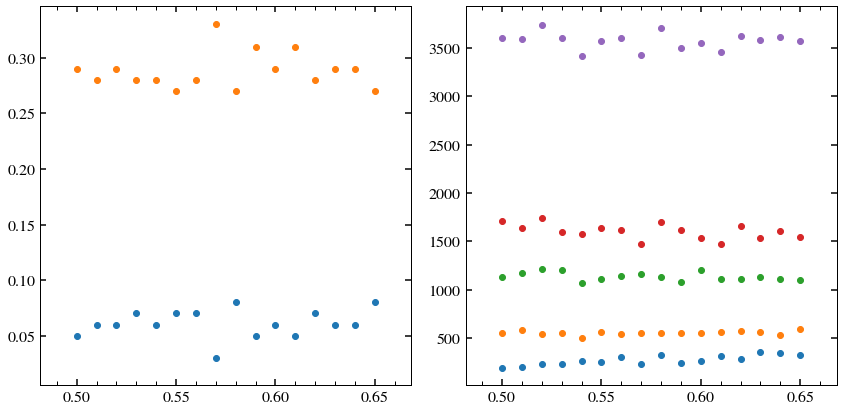

sigma_sham,chisq0,chisq1,chisq2,chisq3,pct_diff_1h,pct_diff_2h
float64,float64,float64,float64,float64,float64,float64
0.5,190.0,557.0,1135.0,1715.0,0.05,-0.29
0.51,200.0,585.0,1174.0,1635.0,0.06,-0.28
0.52,236.0,543.0,1210.0,1744.0,0.06,-0.29
0.53,238.0,555.0,1209.0,1596.0,0.07,-0.28
0.54,266.0,503.0,1071.0,1571.0,0.06,-0.28
0.55,259.0,565.0,1109.0,1640.0,0.07,-0.27
0.56,302.0,543.0,1145.0,1614.0,0.07,-0.28
0.57,232.0,550.0,1162.0,1476.0,0.03,-0.33
0.58,322.0,552.0,1131.0,1700.0,0.08,-0.27


In [9]:
this_band = band
this_zmin = zmin

this_zsim      = np.array(z_snaps)[ np.round(z_snaps,1)==this_zmin ][0]
this_zsnap_tag = get_zsnap_tag(this_zsim)

t = np.load( f"{BASEDIR}/summary_{this_band}_{this_zsnap_tag}.npy" )

mask = (np.abs(t["pct_diff_1h"])==np.min(np.abs(t["pct_diff_1h"]))) & (np.abs(t["pct_diff_2h"])==np.min(np.abs(t["pct_diff_2h"])))

fig, axes = plt.subplots(1, 2, figsize=(12,6))

ax = axes[0]
ss = t["sigma_sham"]
ax.scatter(ss, np.abs(t["pct_diff_1h"]))
ax.scatter(ss, np.abs(t["pct_diff_2h"]))

ax = axes[1]
ax.scatter(ss, t["chisq0"])
ax.scatter(ss, t["chisq1"])
ax.scatter(ss, t["chisq2"])
ax.scatter(ss, t["chisq3"])

ax.scatter(ss, np.sum( [t[f"chisq{i}"] for i in range(4)], axis=0 ))

plt.tight_layout()
plt.show()

Table(t)#[mask])
#Table(t[(t["sigma_sham"]==0.77) | (t["sigma_sham"]==0.8)])



In [ ]:
# %%time

# f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{mock_scatter_tag}_{rp_use_tag}"

# #-- galaxies with magnitudes, colors, LRG flags
# galcat_fname = f"{f}_galcat_LRG-flagged.npy"

# #-- galaxies with magnitudes
# galcat_fname = f"{f}.npy"

# print(galcat_fname)

# cat = Table(np.load(galcat_fname))
